In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2
import shutil
import random
import pandas as pd

In [2]:
NUMBER_OF_CLASSES = 21

EDA

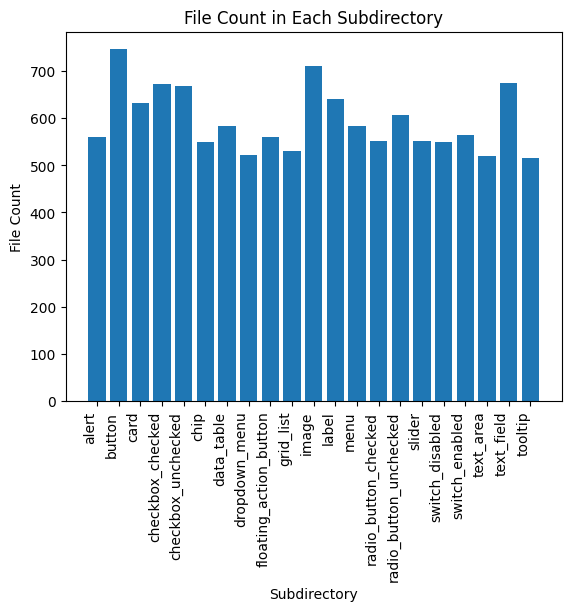

In [3]:

base_dir = "./data/ui_icons_dataset/"
train_dir = (os.path.join(base_dir,"train/"))

file_counts = []

for dir in os.listdir(train_dir):
    dir_path = os.path.join(train_dir,dir)
    file_counts.append(len(os.listdir(dir_path)))

plt.bar(os.listdir(train_dir), file_counts)
plt.xlabel('Subdirectory')
plt.ylabel('File Count')
plt.title('File Count in Each Subdirectory')
plt.xticks(rotation=90, ha='right') 
plt.show()

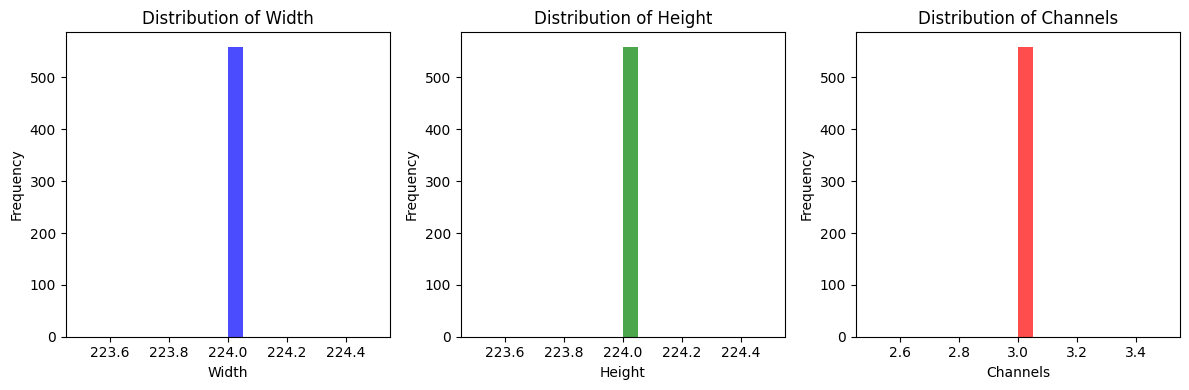

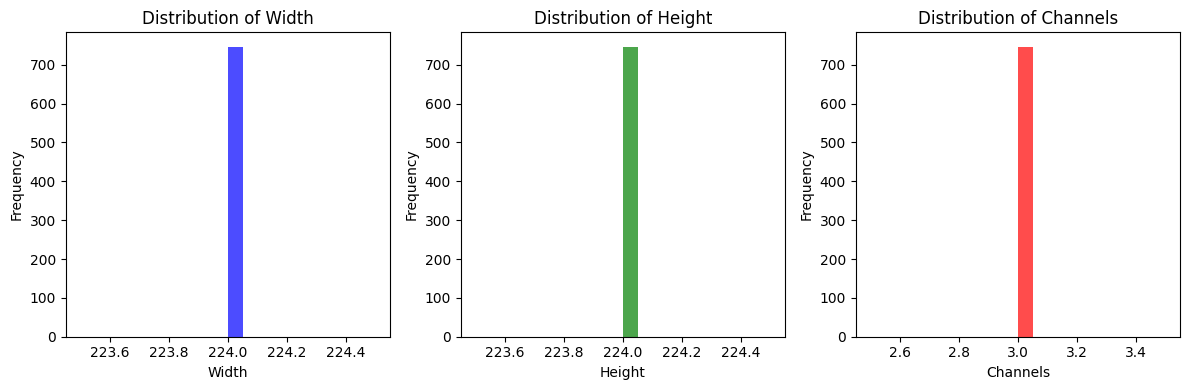

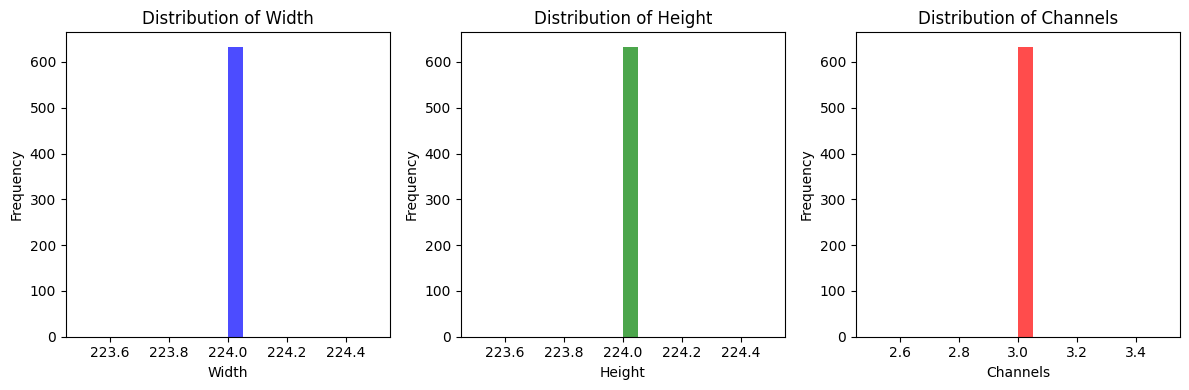

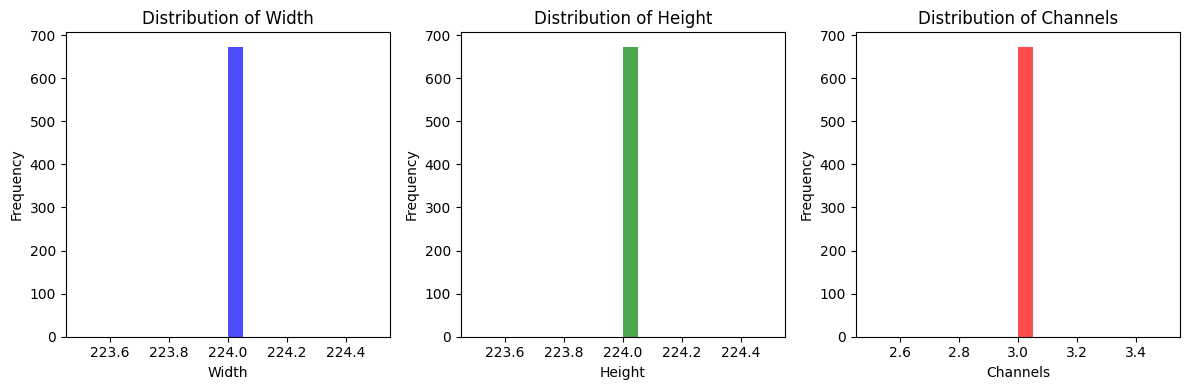

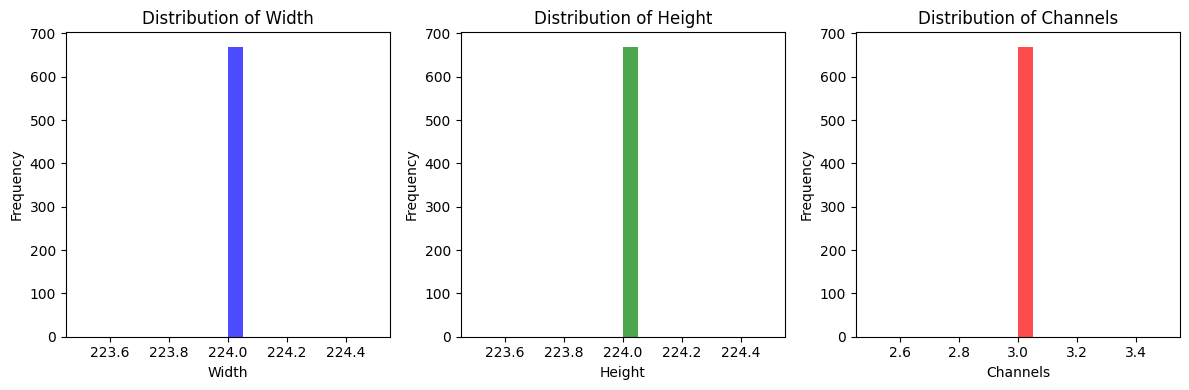

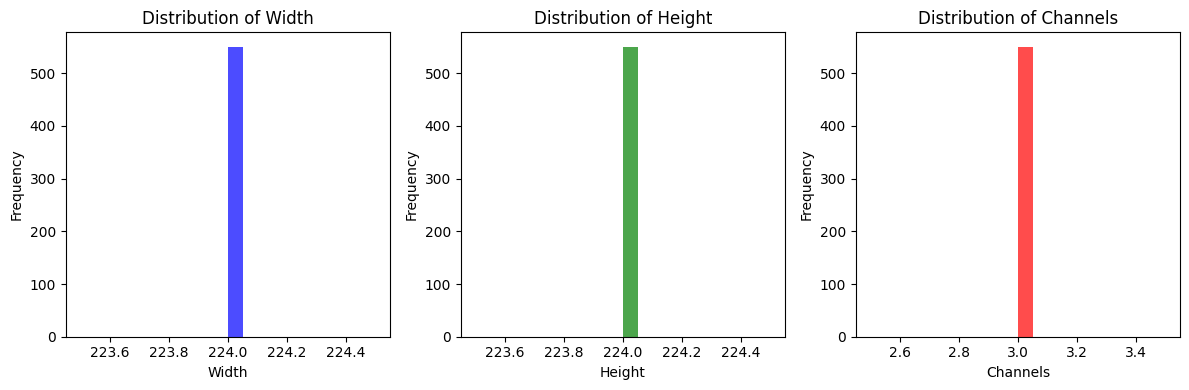

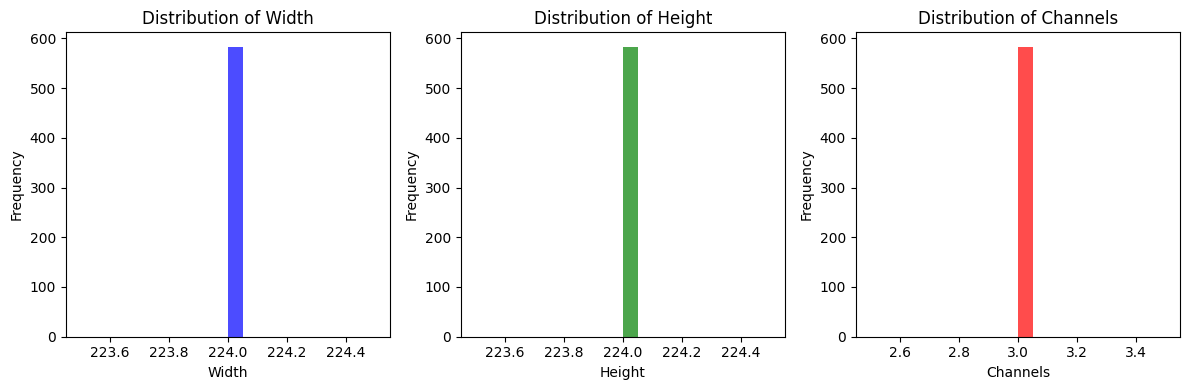

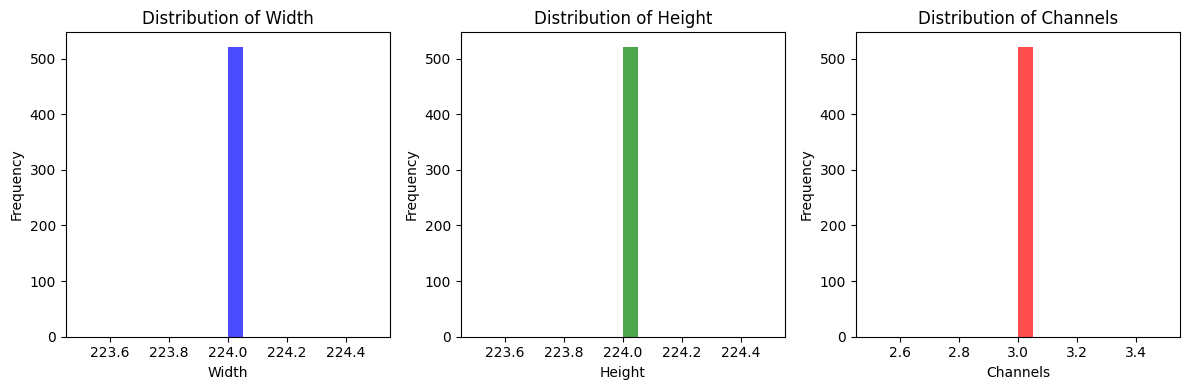

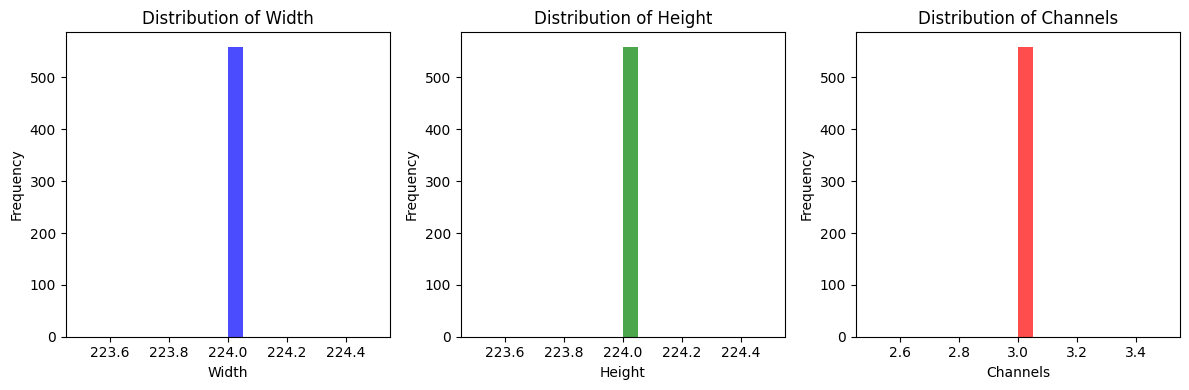

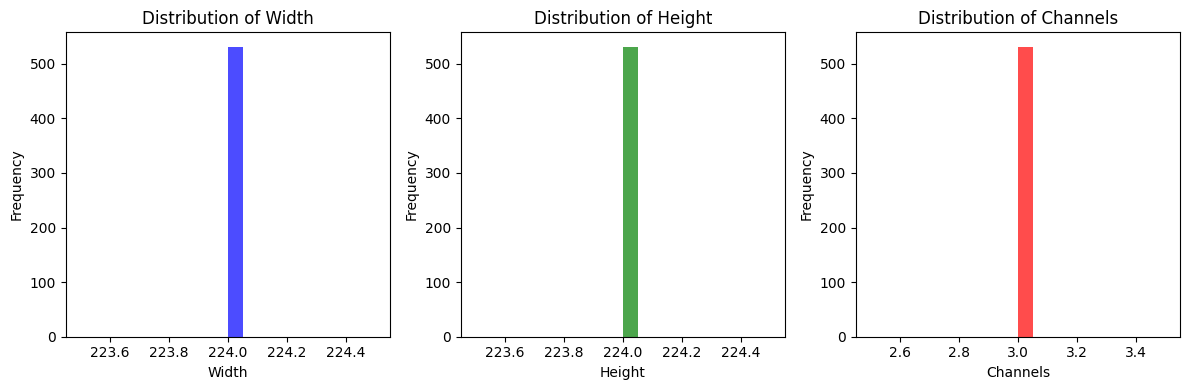

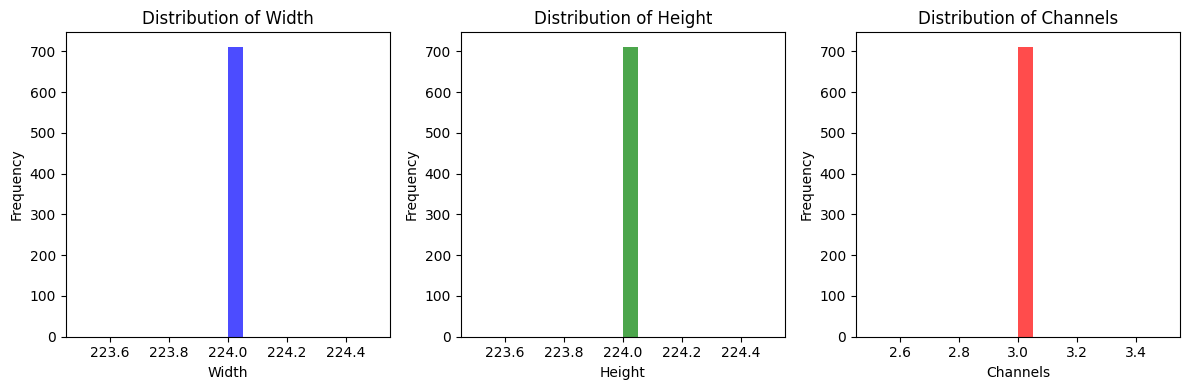

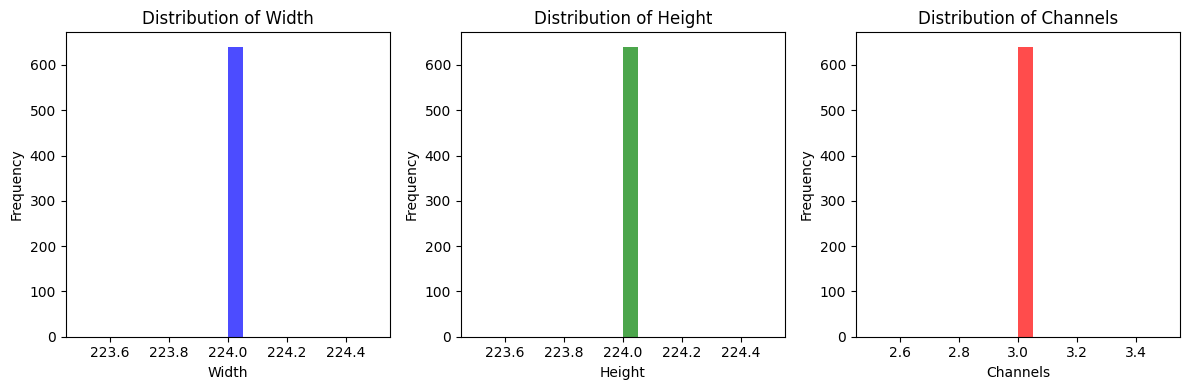

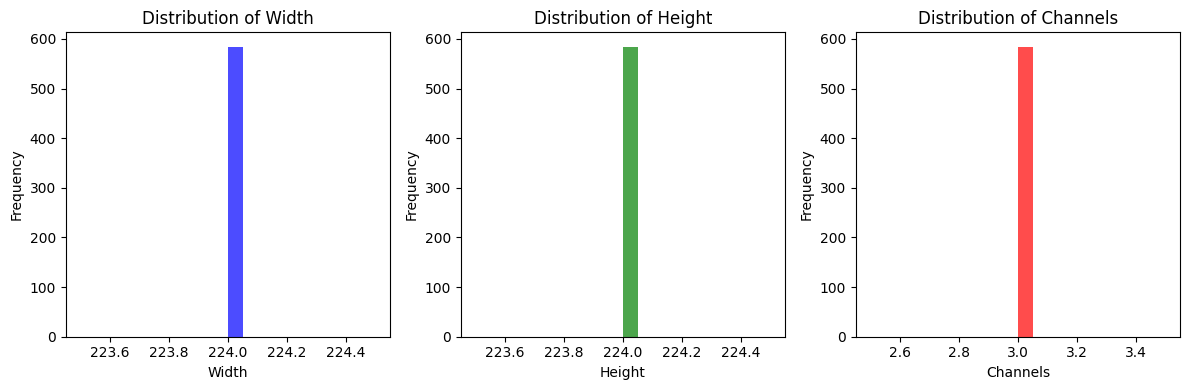

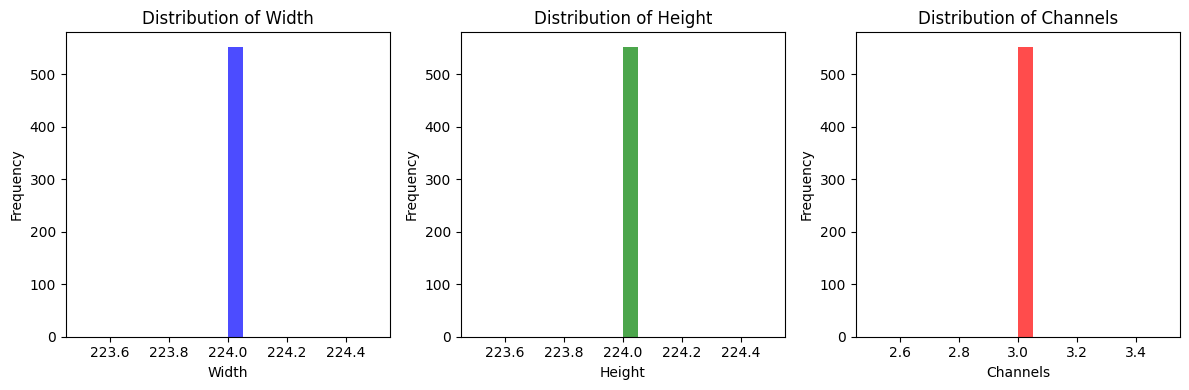

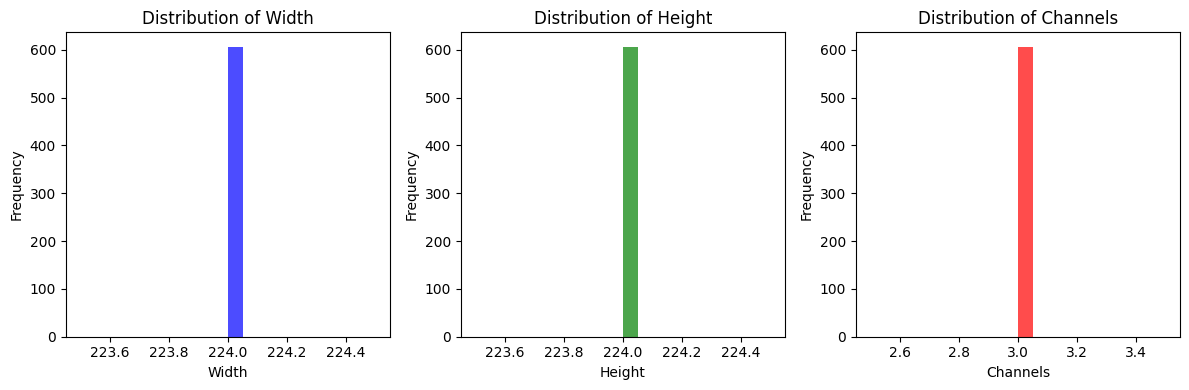

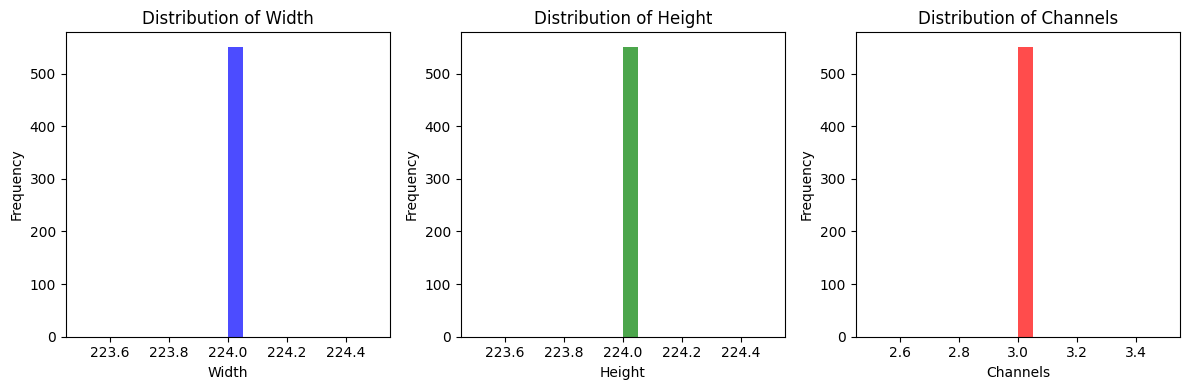

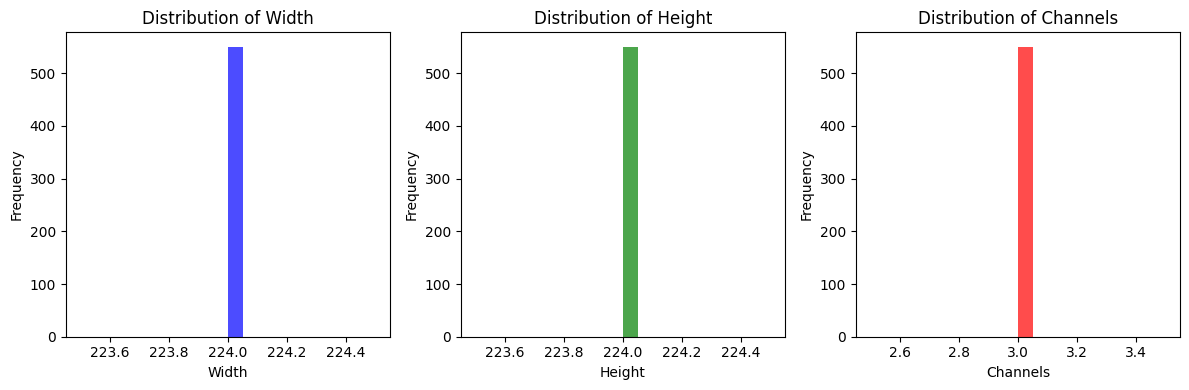

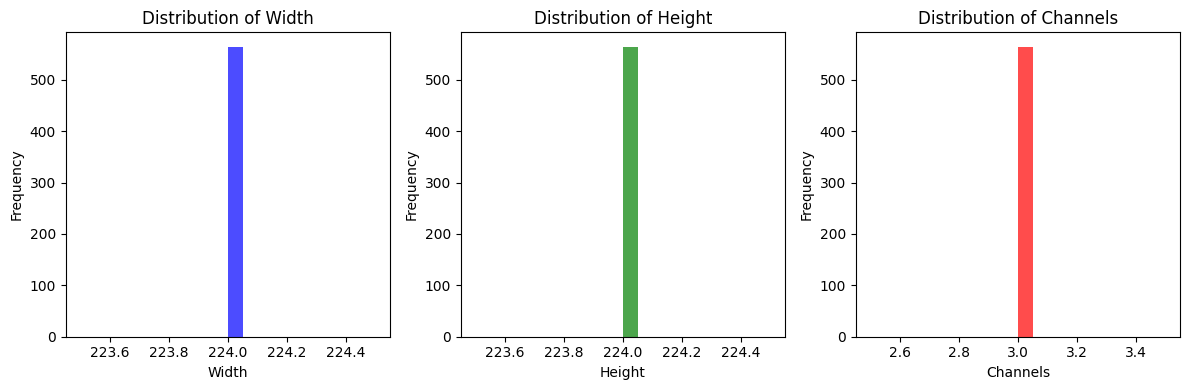

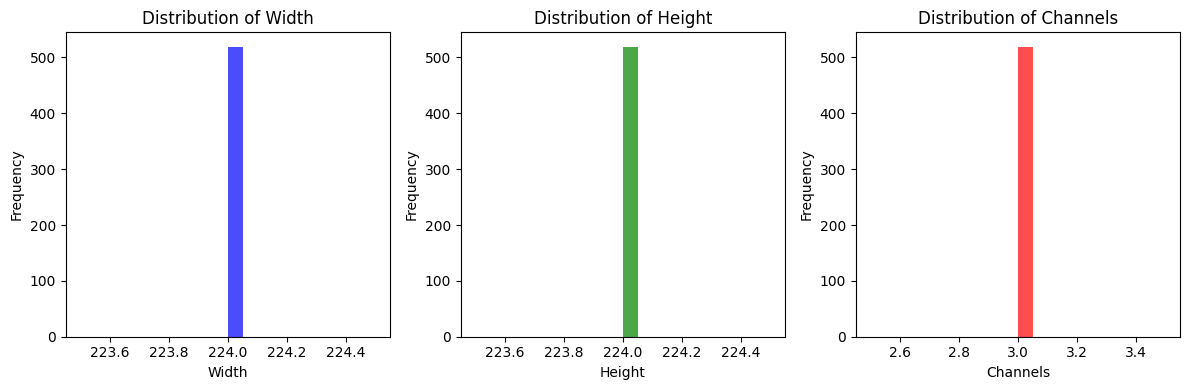

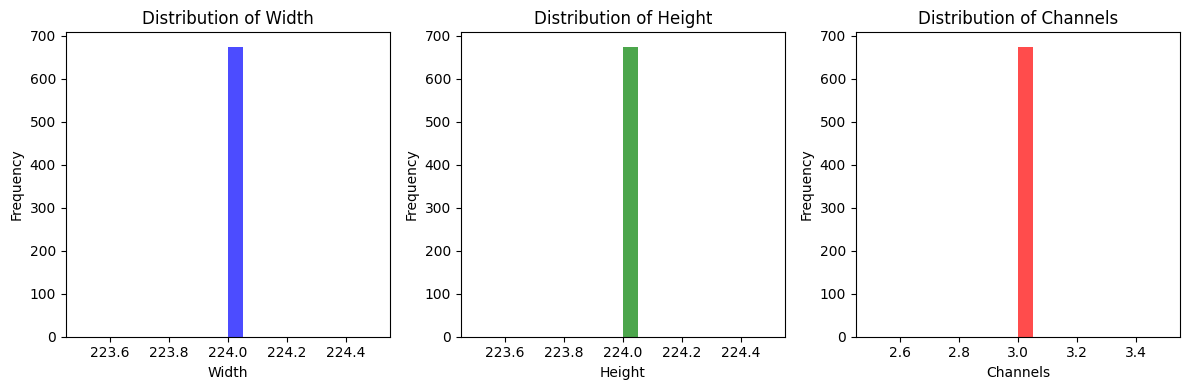

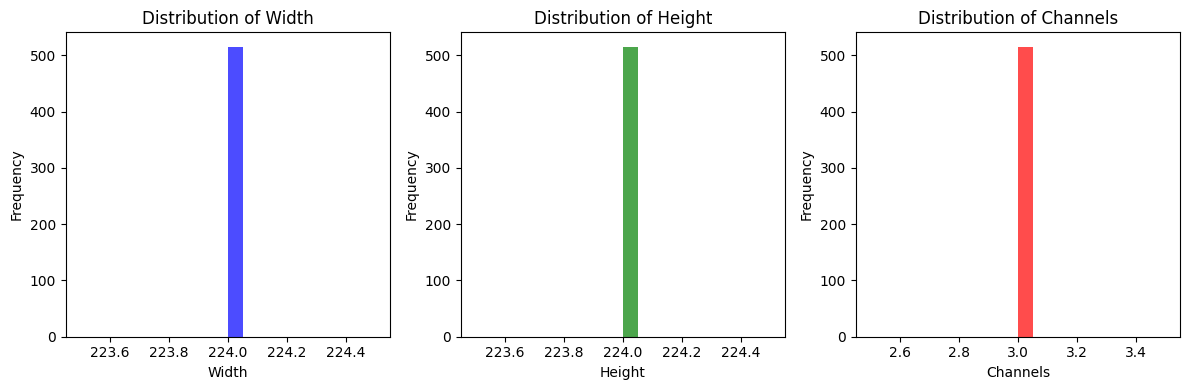

In [4]:
for dir in os.listdir(train_dir):
    img_x = []
    img_y = []
    img_c = []
    dir_path = os.path.join(train_dir, dir)

    for img in os.listdir(dir_path):
        img_path = os.path.join(dir_path, img)
        image = cv2.imread(img_path)

        img_x.append(image.shape[0])
        img_y.append(image.shape[1])
        img_c.append(image.shape[2])

    # Display the distribution of width
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(img_x, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title('Distribution of Width')

    # Display the distribution of height
    plt.subplot(1, 3, 2)
    plt.hist(img_y, bins=20, color='green', alpha=0.7)
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title('Distribution of Height')

    # Display the distribution of channels
    plt.subplot(1, 3, 3)
    plt.hist(img_c, bins=20, color='red', alpha=0.7)
    plt.xlabel('Channels')
    plt.ylabel('Frequency')
    plt.title('Distribution of Channels')

    plt.tight_layout()
    plt.show()


In [5]:


validation_dir = os.path.join(base_dir, "validation/")

# Create the validation directory if it doesn't exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

# Percentage of data to move to validation set
validation_percentage = 0.1

# Iterate through each class folder in the training set
for class_folder in os.listdir(train_dir):
    
    class_train_dir = os.path.join(train_dir, class_folder)
    class_validation_dir = os.path.join(validation_dir, class_folder)

    # Create the validation class folder if it doesn't exist
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    # List all images in the class folder
    all_images = os.listdir(class_train_dir)

    # Calculate the number of images to move to the validation set
    num_validation_images = int(len(all_images) * validation_percentage)

    # Randomly select images for validation
    validation_images = random.sample(all_images, num_validation_images)

    # Move the selected images to the validation set
    for img in validation_images:
        img_path_src = os.path.join(class_train_dir, img)
        img_path_dest = os.path.join(class_validation_dir, img)
        shutil.move(img_path_src, img_path_dest)

print("Validation set created successfully.")


Validation set created successfully.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=60,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 11249 images belonging to 21 classes.
Found 4150 images belonging to 21 classes.


In [7]:
EPOCHS = 10

In [8]:
from keras.applications import VGG16
def create_model():
    batch_size = 20
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
# Create a new model
model = create_model()

#Train the model
history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=1)




Epoch 1/10


120/563 [=====>........................] - ETA: 13:24 - loss: 2.5573 - accuracy: 0.2424

KeyboardInterrupt: 

In [ ]:
model_save_path = 'tl_vgg16'

# Save the model
model.save(model_save_path)

In [ ]:
model_test  = tf.keras.models.load_model('tl_vgg16')

base_dir = "./data/ui_icons_dataset/"
test_dir = os.path.join(base_dir, "test/test")

IDs2 = []
Target2 = []

for i in range(len(os.listdir(test_dir))):
    image = cv2.imread(os.path.join(test_dir,os.listdir(test_dir)[i]))
    image = cv2.resize(image,(224,224)) 
    image = image.reshape(1,224,224,3)

    IDs2.append(os.listdir(test_dir)[i])

    prediction = model_test.predict(image)
    max_index = np.argmax(prediction)

    Target2.append(os.listdir(train_dir)[max_index])
            


1/1 [==============================] - 0s 142ms/step


In [ ]:
df2 = pd.DataFrame({'ID': IDs2, 'Target': Target2})

In [ ]:
df2.to_csv('predictions_vvg16.csv', index=False)

In [ ]:
print(df2)